In [2]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np 
import matplotlib.pyplot as plt

# inline magic changes figsize, set it again here
import matplotlib
matplotlib.rcParams['figure.figsize'] = 8,6 
default_color_list = plt.rcParams['axes.prop_cycle'].by_key()['color'] # get default colors

from astropy.table import Table
from astropy.io import ascii

import pathos.multiprocessing as mp

# 2. Plot Cubes
This notebook contains functions for plotting, and plots the cubes we made in the cube making notebook.

In [5]:
def findlevel (H):
    '''Find 68%, 95%, 99% confidence level for a probability 2D plane H. I sort the pixels, and count from highest probability pixel, until I accumulated 68%, 95%, 99% of the probability, and record the values. With these values, you can draw contours on H for 1,2,3 sigmas.
    
    Input:
    H is a probability plane (marginalized over the 3rd parameter)
    
    Output:
    V = [v68, v95, v99]
    This is the 3 values in H that gives the 68%, 95%, 99% confidence level
    '''
    H[np.isnan(H)]=0 ## remove nan's
    H /= float(np.sum(H)) ## normalize the plane to 1
    
    idx = np.argsort(H.flat)[::-1] ## sort H from high to low, this is the index
    H_sorted = H.flat[idx] ## sorted H
    H_cumsum = np.cumsum(H_sorted) ## cumulated sum at each pixel
    ### find the nearest pixel that matches cumulated sum of 1,2,3 sigmas
    idx68 = np.where(abs(H_cumsum-0.683)==np.amin(abs(H_cumsum-0.683)))[0]    
    idx95 = np.where(abs(H_cumsum-0.955)==np.amin(abs(H_cumsum-0.955)))[0]
    idx99 = np.where(abs(H_cumsum-0.997)==np.amin(abs(H_cumsum-0.997)))[0]
    v68 = float(H.flat[idx[idx68]])
    v95 = float(H.flat[idx[idx95]])
    v99 = float(H.flat[idx[idx99]])
    V = [v68, v95, v99]
    return V

def plot_cube_getdist_style(cube, axis_numbers,
              fig=None, axes=None, 
              label_list = [r'$M_{\nu}(eV)$', r'$\Omega_m$', r'$\sigma_8$'], 
              input_label = 'experiment',
              input_color = 'blue',
              fill=False, **kwargs):
    """Convenience function for quick plotting of a cube
    cube is 3D numpy array full of probabilities
    axis_numbers is a list of 1D numpy arrays used for axes.
    label_list is a list of strings to be used as label
    kwargs are passed to contour
    """
    
    num_vars = len(label_list)
    inds = list(range(num_vars))
    
    if fig is None or axes is None:
        fig, axes = plt.subplots(1,num_vars,figsize=(20,6.5))
    
    

    for i, ax in enumerate(axes):
        tot = np.sum(cube.flatten())
        flattened = np.sum(cube, axis=i) / tot
        
        x_axis_ind, y_axis_ind = inds[:i] + inds[i+1:]
        
        X_AX, Y_AX = np.meshgrid(axis_numbers[x_axis_ind], 
                                 axis_numbers[y_axis_ind], 
                                 indexing='ij')
        if fill:
            
            color0 = matplotlib.colors.to_rgba(input_color)
            color1 = list(color0)
            color1[-1] = 0.3
            color2 = list(color0)
            color2[-1] = 0.6
            
            c_68, c_95, c_99 = findlevel(flattened)
            last_cont = np.max(flattened)
            ax.contourf( X_AX, Y_AX,
                   flattened,levels=[c_95, c_68,last_cont*2], colors=(color1, color2), **kwargs)
            ax.contour(  X_AX, Y_AX,
                       flattened, levels=[c_95, c_68], colors=(color0,))
            # generate fake histogram for legend
            ax.plot([], '-', color=color2, label=input_label, lw=3)
            
        else:
            
            c_68, c_95, c_99 = findlevel(flattened)
            ax.contour(  X_AX, Y_AX,
                       flattened, levels=[c_95, c_68], **kwargs)
            
        ax.set_xlabel(label_list[x_axis_ind])
        ax.set_ylabel(label_list[y_axis_ind])

    return fig, axes

## noisy contours: galaxy tomography

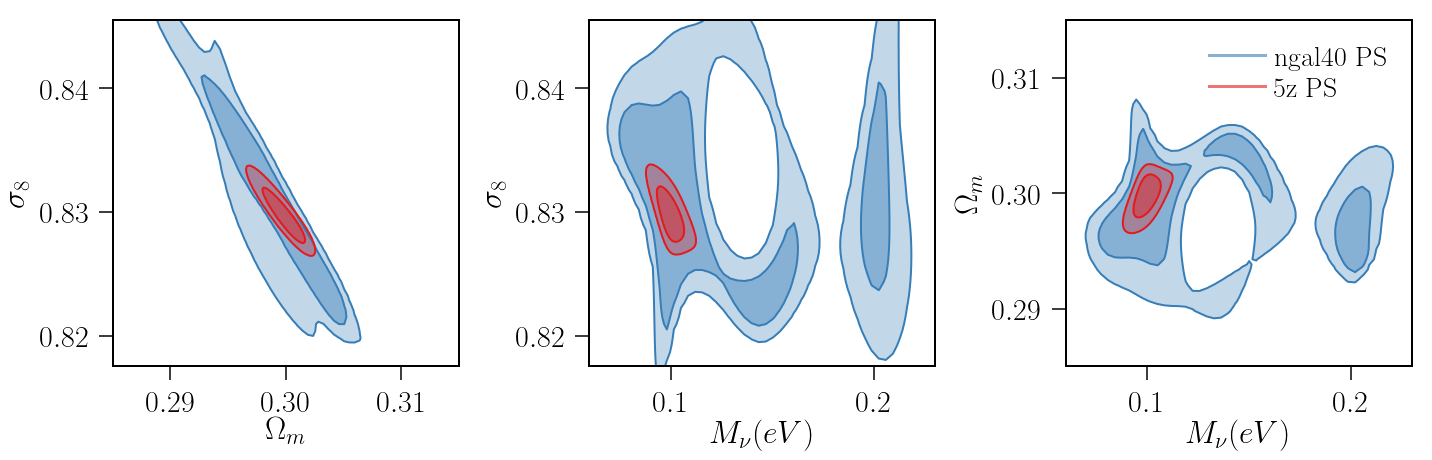

In [34]:
x,y,z = np.load(  'cubes/ngal40_PS_xyz.npy' )
c2 = np.load( 'cubes/ngal40_PS.npy' )
fig, axes = plot_cube_getdist_style(c2, [x,y,z], fill=True, 
                        input_color=default_color_list[2],
                       input_label='ngal40 PS')


x,y,z =  np.load( 'cubes/5z_5000_PS_xyz.npy' )
c2 = np.load(  'cubes/5z_5000_PS.npy' )
fig, axes = plot_cube_getdist_style(c2, [x,y,z],fig=fig,axes=axes,fill=True, 
                        input_color=default_color_list[1],
                       input_label='5z PS')

axes[-1].legend()

# some adjustment to make the legend not overlap with data
axes[-1].set_ylim(0.285,0.315)
axes[0].set_xlim(0.285,0.315)

plt.tight_layout()
# fig.savefig('figures/fig_ngal40_vs_5z.pdf')

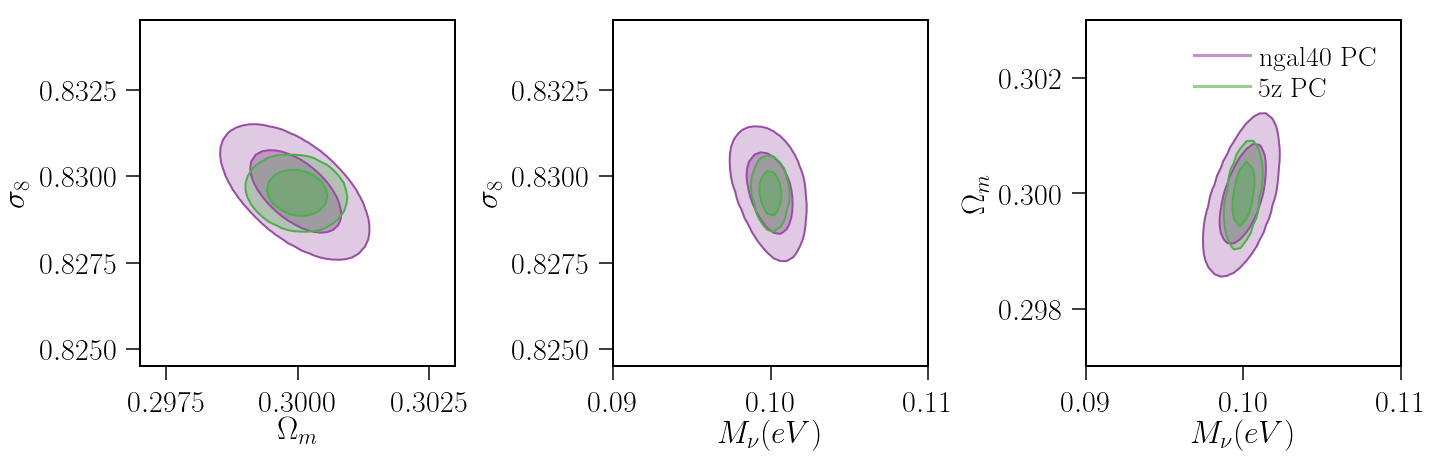

In [44]:
x,y,z = np.load(  'cubes/ngal40_PC_xyz.npy' )
c2 = np.load( 'cubes/ngal40_PC.npy' )
fig, axes = plot_cube_getdist_style(c2, [x,y,z], fill=True, 
                        input_color=default_color_list[4],
                       input_label='ngal40 PC')


x,y,z =  np.load( 'cubes/5z_5000_PC_xyz.npy' )
c2 = np.load(  'cubes/5z_5000_PC.npy' )
fig, axes = plot_cube_getdist_style(c2, [x,y,z],fig=fig,axes=axes,fill=True, 
                        input_color=default_color_list[3],
                       input_label='5z PC')

axes[-1].legend()

# some adjustment to make the legend not overlap with data
# axes[-1].set_ylim(0.285,0.315)
# axes[0].set_xlim(0.285,0.315)

plt.tight_layout()
# fig.savefig('figures/fig_ngal40_vs_5z.pdf')

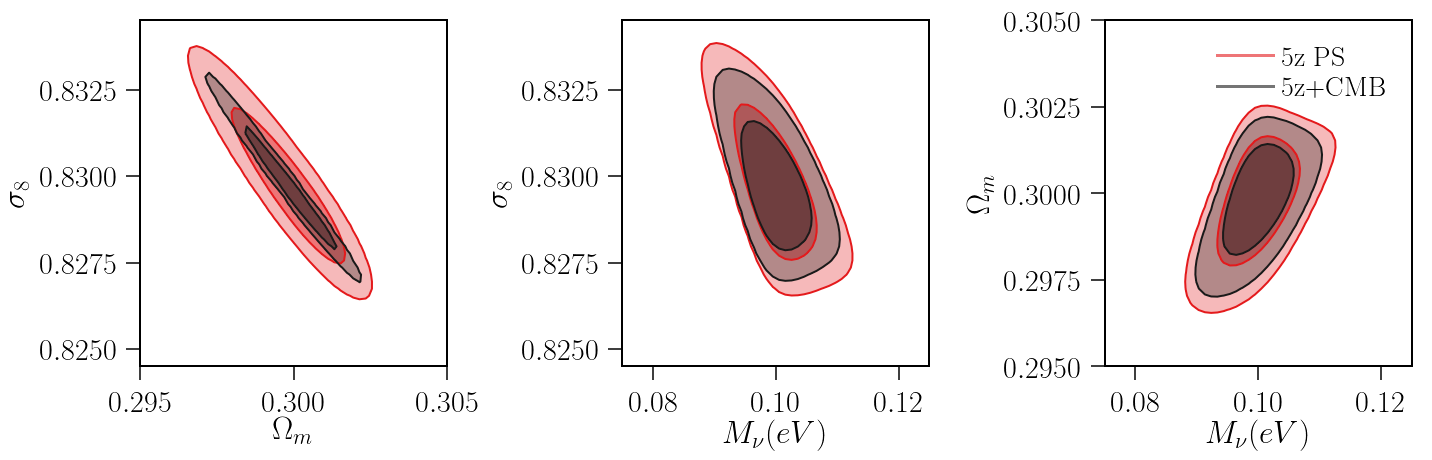

In [43]:


x,y,z =  np.load( 'cubes/5z_5000_PS_xyz.npy' )
c2 = np.load(  'cubes/5z_5000_PS.npy' )
fig, axes = plot_cube_getdist_style(c2, [x,y,z],fill=True, 
                        input_color=default_color_list[1],
                       input_label='5z PS')

x,y,z = np.load(  'cubes/5z_CMB_PS_xyz.npy' )
c2 = np.load( 'cubes/5z_CMB_PS.npy' )
fig, axes = plot_cube_getdist_style(c2, [x,y,z],fig=fig,axes=axes, fill=True, 
                        input_color=default_color_list[0],
                       input_label='5z+CMB')

axes[-1].legend()
    
plt.tight_layout()
# fig.savefig('figures/fig_ngal40_vs_5z.pdf')

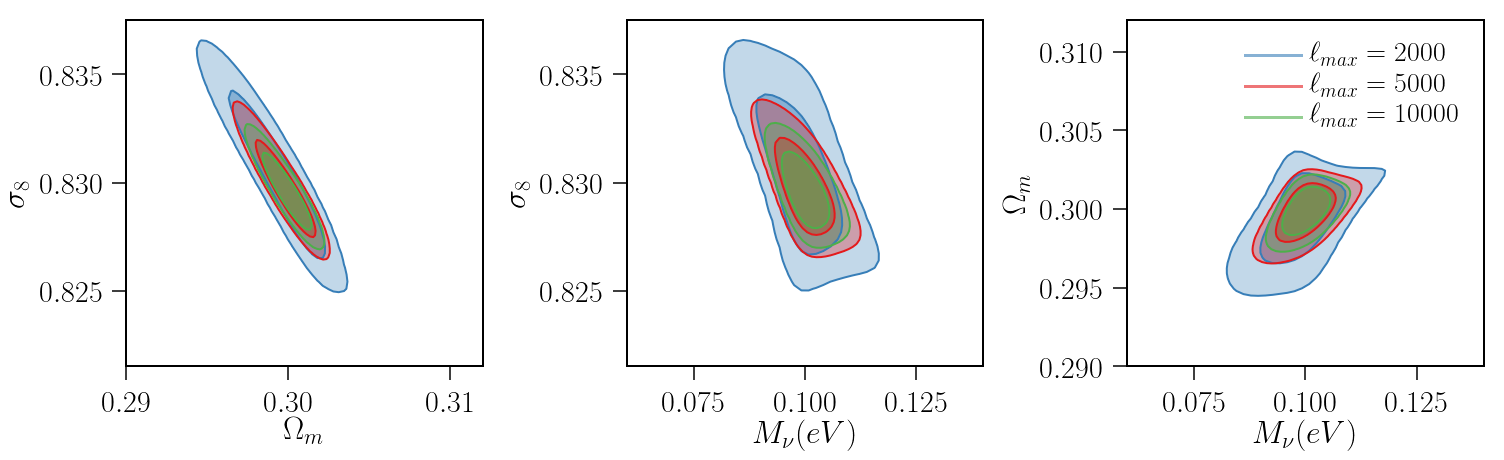

In [27]:
fig, axes = plt.subplots(1,3,figsize=(21,6.5))

x,y,z = np.load(  'cubes/5z_2000_PS_xyz.npy' )
c2 = np.load( 'cubes/5z_2000_PS.npy' )
fig, axes = plot_cube_getdist_style(c2, [x,y,z], fig=fig, axes=axes, fill=True, 
                        input_color=default_color_list[2],
                       input_label=r'$\ell_{max} = 2000$')

x,y,z = np.load(  'cubes/5z_5000_PS_xyz.npy' )
c2 = np.load( 'cubes/5z_5000_PS.npy' )
fig, axes = plot_cube_getdist_style(c2, [x,y,z], fig=fig, axes=axes, fill=True, 
                        input_color=default_color_list[1],
                       input_label=r'$\ell_{max} = 5000$')


x,y,z = np.load(  'cubes/5z_10000_PS_xyz.npy' )
c2 = np.load( 'cubes/5z_10000_PS.npy' )
fig, axes = plot_cube_getdist_style(c2, [x,y,z], fig=fig, axes=axes, fill=True, 
                        input_color=default_color_list[3],
                       input_label=r'$\ell_{max} = 10000$')


# some adjustment to make the legend not overlap with data
axes[-1].set_ylim(0.29,0.312)
axes[0].set_xlim(0.29,0.312)

axes[-1].legend()
    
plt.tight_layout()
# fig.savefig('figures/fig_ngal40_vs_5z.pdf')